In [5]:
import sys
sys.path.append('..')
from mp_api.client import MPRester
from emmet.core.symmetry import CrystalSystem
import numpy as np
import pandas as pd
from configs.silica import allegro
import tqdm
from matplotlib import pyplot as plt
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import ase
from symphony.data import input_pipeline, input_pipeline_tf, fragments
from symphony import datatypes
import jax.random
import jax.numpy as jnp
import jraph
import tensorflow as tf
import itertools
import ml_collections
import os
import yaml
import re
import matscipy

sys.path.append('../configs/silica/allegro.py')
import configs.silica.allegro as allegro

In [2]:
# query and download data
with MPRester("NA4RS6zGonPp3S3TQTSBPkzevjE3jAPt") as mpr:
    docs = mpr.materials.summary.search(elements=["Si", "O"], num_elements=(2, 2))

Retrieving SummaryDoc documents:   0%|          | 0/343 [00:00<?, ?it/s]

In [21]:
SpacegroupAnalyzer(cubic[0].structure, symprec=0.1).get_conventional_standard_structure().lattice
# docs[0].structure.lattice

Lattice
    abc : 19.08788596382031 19.08788596382031 19.08788596382031
 angles : 90.0 90.0 90.0
 volume : 6954.621442373826
      A : 19.08788596382031 0.0 1.1687959224041117e-15
      B : 3.069566175286419e-15 19.08788596382031 1.1687959224041117e-15
      C : 0.0 0.0 19.08788596382031
    pbc : True True True

In [22]:
cubic = []
for d in docs:
    sga = SpacegroupAnalyzer(d.structure, symprec=0.1)
    if sga.get_crystal_system() == 'cubic':
        cubic.append(sga.get_conventional_standard_structure())

spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-01 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 2 tolerance = 9.025000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 3 tolerance = 8.573750e-02 failed(line 800, /project/src/spacegroup.c).


In [23]:
lattices = [ s.lattice for s in cubic]

In [24]:
lattices

[Lattice
     abc : 19.08788596382031 19.08788596382031 19.08788596382031
  angles : 90.0 90.0 90.0
  volume : 6954.621442373826
       A : 19.08788596382031 0.0 1.1687959224041117e-15
       B : 3.069566175286419e-15 19.08788596382031 1.1687959224041117e-15
       C : 0.0 0.0 19.08788596382031
     pbc : True True True,
 Lattice
     abc : 3.807044 3.807044 3.807044
  angles : 90.0 90.0 90.0
  volume : 55.17771207397914
       A : 3.807044 0.0 2.331142124406568e-16
       B : 6.12219368471554e-16 3.807044 2.331142124406568e-16
       C : 0.0 0.0 3.807044
     pbc : True True True,
 Lattice
     abc : 14.8938297 14.8938297 14.8938297
  angles : 90.0 90.0 90.0
  volume : 3303.8410967013933
       A : 14.8938297 0.0 9.119840434575392e-16
       B : 2.395110488099658e-15 14.8938297 9.119840434575392e-16
       C : 0.0 0.0 14.8938297
     pbc : True True True,
 Lattice
     abc : 15.552478 15.552478 15.552478
  angles : 90.0 90.0 90.0
  volume : 3761.8267212537953
       A : 15.552478 0.0 

In [60]:
struct = docs[1].structure
mol = ase.Atoms(
    positions=struct.cart_coords,
    numbers=struct.atomic_numbers,
    cell=struct.lattice.matrix,
    pbc=True,
)

In [61]:
senders, receivers = matscipy.neighbours.neighbour_list('ij', mol, cutoff=5.0,)

In [62]:
mol.cell

Cell([8.519192, 14.198571, 16.049878])

In [63]:
i = 19

In [64]:
(mol.positions[receivers] - mol.positions[senders])[i]

array([-6.07086141, -1.58244494,  0.98742059])

In [66]:
input_pipeline.get_relative_positions(mol.positions, senders, receivers, mol.cell, True)[i]

array([ 2.44833059, -1.58244494,  0.98742059])

some statistics

In [4]:
splits = ['train'] * 250 + ['val'] * 50 + ['test'] * 50

In [14]:
num_atoms = {'train': [], 'val': [], 'test': []}
bond_distances = {'train': [], 'val': [], 'test': []}  # not actually bonds :P
nn = CrystalNN()
for ndx, item in tqdm.tqdm(enumerate(docs)):
    struct = item.structure
    cell = struct.lattice.matrix
    num_atoms[splits[ndx]].append(item.nsites)
    for i in range(item.nsites):
        nn_info = nn.get_nn_info(struct, i)
        for neighbor in nn_info:
            bond_distances[splits[ndx]].append(neighbor['site'].nn_distance)
            # vec = struct[i].frac_coords
            # n_vec = neighbor['site'].frac_coords + neighbor['site'].image
            # bond_angles.append(np.arccos(np.dot(vec, n_vec) / np.linalg.norm(vec) / np.linalg.norm(n_vec)))

num_atoms = {k: np.asarray(v) for k, v in num_atoms.items()}
bond_distances = {k: np.asarray(v) for k, v in bond_distances.items()}

0it [00:00, ?it/s]/home/songk/miniforge3/envs/silica-dev/lib/python3.10/site-packages/pymatgen/analysis/local_env.py:4135: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/home/songk/miniforge3/envs/silica-dev/lib/python3.10/site-packages/pymatgen/analysis/local_env.py:3928: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
343it [26:32,  4.64s/it]


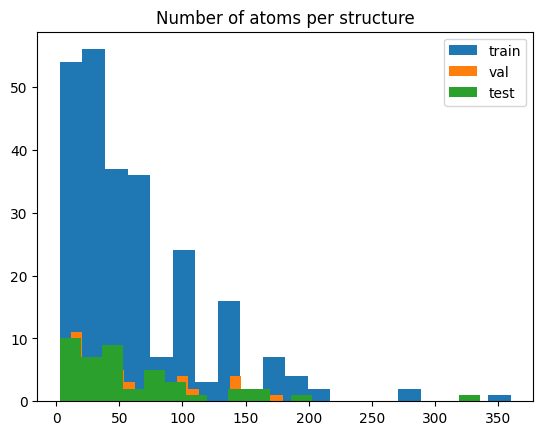

In [28]:
for split in ['train', 'val', 'test']:
    plt.hist(num_atoms[split], label=split, bins=20,)
plt.legend()
plt.title('Number of atoms per structure')
plt.show()

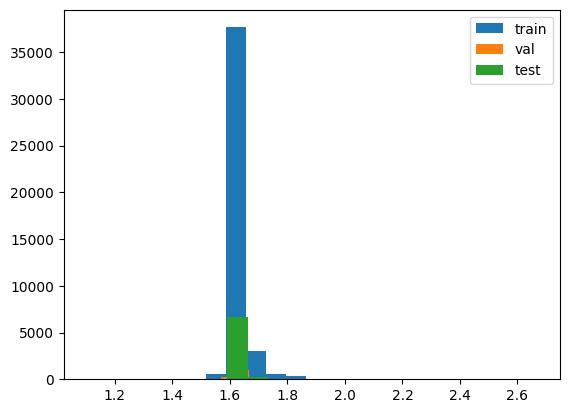

In [27]:
for split in ['train', 'val', 'test']:
    plt.hist(x=bond_distances[split], label=split, bins=20)
plt.legend()
plt.show()

structure matcher

In [4]:
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.core import Structure
import os
import rdkit.Chem as Chem
from analyses import metrics

In [5]:
db_dir = "/home/songk/spherical-harmonic-net/conditional_generation/analysed_workdirs/test/silica-allegro-200k-train-steps-all-dec29/fait=1.0/pit=1.0/step=best/molecules/"
i = 4
molecules = []
with ase.db.connect(os.path.join(db_dir, f"generated_molecules_init=mol_{i}.db")) as db:
    for row in db.select():
        molecules.append(row.toatoms())

In [58]:
for i in range(len(molecules)):
    ase.io.write(f"example_out_{i}.xyz", molecules[i])

In [6]:
beta_species = 1.0
beta_position = 1.0
step = "best"
num_seeds_per_chunk = 1
max_num_atoms = 200  # ?
visualize = False
num_mols = 5
config = allegro.get_config()

molecules = input_pipeline_tf.get_raw_silica_datasets(config)
mols_by_split = {"train": [], "test": []}

# Root directory of the dataset.
filenames = sorted(os.listdir(config.root_dir))
filenames = [
    os.path.join(config.root_dir, f)
    for f in filenames
    if f.startswith("fragments_")
]
if len(filenames) == 0:
    raise ValueError(f"No files found in {config.root_dir}.")

# Partition the filenames into train, val, and test.
def filter_by_molecule_number(
    filenames, start: int, end: int
):
    def filter_file(filename: str, start: int, end: int) -> bool:
        filename = os.path.basename(filename)
        _, file_start, file_end = [int(val) for val in re.findall(r"\d+", filename)]
        return start <= file_start and file_end <= end

    return [f for f in filenames if filter_file(f, start, end)]

# Number of molecules for training can be smaller than the chunk size.
chunk_size = int(filenames[0].split("_")[-1])
train_on_split_smaller_than_chunk = config.get("train_on_split_smaller_than_chunk")
if train_on_split_smaller_than_chunk:
    train_molecules = (0, chunk_size)
else:
    train_molecules = config.train_molecules
files_by_split = {
    "train": filter_by_molecule_number(filenames, *train_molecules),
    "test": filter_by_molecule_number(filenames, *config.test_molecules),
}

element_spec = tf.data.Dataset.load(filenames[0]).element_spec
for split, files in files_by_split.items():
    dataset_split = tf.data.Dataset.from_tensor_slices(files)
    dataset_split = dataset_split.interleave(
        lambda x: tf.data.Dataset.load(x, element_spec=element_spec),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    dataset_split = dataset_split.map(
        input_pipeline_tf._convert_to_graphstuple,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )
    mols_by_split[split] = list(dataset_split.as_numpy_iterator())

# mols_by_split['train'] = mols_by_split['train'][:num_mols]
# mols_by_split['test'] = mols_by_split['test'][-num_mols:]

Retrieving SummaryDoc documents:   0%|          | 0/343 [00:00<?, ?it/s]

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14253332890173845436
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14253332890173845436
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

In [20]:
ase_mols_by_split = {'train': [], 'test': []}
for split, mols in mols_by_split.items():
    for mol in mols:
        ase_mols_by_split[split].append(
            ase.Atoms(
                positions=mol.nodes.positions,
                numbers=get_atomic_numbers(
                    mol.nodes.species
                ),
                cell=np.squeeze(mol.globals.cell, axis=0),
                pbc=True
            )
        )
import pickle
with open('ase_mols_by_split.pkl', 'wb') as f:
    pickle.dump(ase_mols_by_split, f)

In [7]:
def ase_to_structure(mol):
    return Structure(mol.get_cell(), mol.get_atomic_numbers(), mol.get_positions())

def structure_to_ase(struct):
    return ase.Atoms(positions=struct.cart_coords, numbers=struct.atomic_numbers, cell=struct.lattice.matrix)

def ase_to_rdkit(mol):
    ase.io.write('/tmp/test.xyz', mol)
    return Chem.MolFromXYZFile("/tmp/test.xyz")

def graphstuple_to_ase(graph):
    return ase.Atoms(positions=graph.nodes.positions, numbers=np.vectorize(lambda x: 14 if x else 8)(graph.nodes.species))

In [53]:
for i in range(10):
    ase.io.write(f"example_{i}.xyz", graphstuple_to_ase(mols_by_split['train'][i]))

In [8]:
rdkit_mol = ase_to_rdkit(structure_to_ase(structures[0]))
metrics.get_posebusters_results([rdkit_mol])  # what's the steric clash check? is there a cutoff?

,,mol_pred_loaded,sanitization,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy
file,molecule,,,,,,,,,
<rdkit.Chem.rdchem.Mol object at 0x7fea486a98c0>,mol_at_pos_0,True,True,False,True,True,False,True,True,False


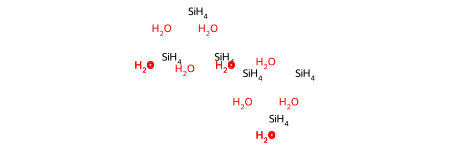

In [11]:
rdkit_mol

In [22]:
# CDVAE (https://arxiv.org/pdf/2110.06197.pdf) uses this for similarity to original structure
for struct in structures:
    if StructureMatcher().fit(ase_to_structure(ase.Atoms(symbols="CO2")), struct):
        print(struct)
        break

False